In [28]:
import torch
from env import CholeskyTaskGraph, Task
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import torch.nn.functional as F
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import seaborn as sns
import time
sns.set()


In [61]:
# model = torch.load('/home/nathan/PycharmProjects/HPC/runs/Apr13_14-24-24_nathan-Latitude-7490/model.pth')

# model = torch.load("/home/nathan/PycharmProjects/HPC/runs/Apr19_19-02-33_nathan-Latitude-7490/model.pth")
# model = torch.load("/home/nathan/PycharmProjects/HPC/runs/Apr20_01-11-05_nathan-Latitude-7490/model.pth") #168
# model = torch.load("/home/nathan/PycharmProjects/HPC/runs/Apr20_05-18-01_chifflot-4.lille.grid5000.fr/model.pth")
# model = torch.load('/home/nathan/PycharmProjects/HPC/runs/Apr25_20-07-37_nathan-Latitude-7490/model.pth')
# model = torch.load('/home/nathan/PycharmProjects/HPC/runs/Apr20_05-12-44_chifflot-4.lille.grid5000.fr_162/model.pth')
# model = torch.load('/home/nathan/PycharmProjects/HPC/runs/Jun26_00-59-47_nathan-Latitude-7490/model.pth') # n=4 (ttf)
# model = torch.load('/home/nathan/PycharmProjects/HPC/runs/Jun26_01-02-31_nathan-Latitude-7490/model.pth') # n = 15

# model = torch.load('/home/nathan/PycharmProjects/HPC/runs/n=8_node_types=[1 1 1 1]_window=1_noise=False_seed=None/input_dim=11/2020-08-14_17:30:16/model_166.0.pth')
# model1 = torch.load("/home/nathan/PycharmProjects/HPC/runs/n=8_node_types=[1 1 1 1]_window=1_noise=False_seed=None/input_dim=11/2020-08-02_22:31:47/model_167.0.pth")
# model2 = torch.load("/home/nathan/PycharmProjects/HPC/runs/n=8_node_types=[1 1 1 1]_window=1_noise=False_seed=None/input_dim=11/2020-08-03_12:19:45/model_168.0.pth")
# model = torch.load("/home/nathan/PycharmProjects/HPC/runs/n=16_node_types=[1 1 1 1]_window=1_noise=0_seed=None/input_dim=11/2020-08-19_17:51:03/model_792.0.pth")
# model = torch.load("/home/nathan/PycharmProjects/HPC/runs/n=4_node_types=[1 1 1 1]_window=1_noise=0_seed=None/input_dim=11/2020-08-19_16:09:15/model_74.0.pth")
# model = torch.load("/home/nathan/PycharmProjects/HPC/runs/n=4_node_types=[1 1 1 1]_window=1_noise=0_seed=None/input_dim=11/2020-08-19_16:08:06/model_74.0.pth")
# model = torch.load("/home/nathan/PycharmProjects/HPC/runs/n=8_node_types=[1 1 1 1]_window=1_noise=False_seed=None/input_dim=11/2020-08-16_19:24:27/model_163.0.pth")
# model = torch.load("/home/nathan/PycharmProjects/HPC/runs/n=8_node_types=[1 1 1 1 1 1]_window=1_noise=0_seed=None/input_dim=11/2020-08-18_23:57:15/model_158.0.pth")
# model = torch.load("/home/nathan/PycharmProjects/HPC/runs/n=8_node_types=[1 1]_window=1_noise=0_seed=None/input_dim=11/2020-08-18_23:21:27/model_280.0.pth")

model = torch.load('/home/nathan/PycharmProjects/HPC/runs/n=8_node_types=[1 1 1 1]_window=1_noise=1_seed=None/input_dim=11/2020-08-17_15:07:29/model_162.40018303447914.pth')

In [71]:
# ns = list(range(1, 15))
# ps = list(range(1, 10))
temp = 1
# ns = [1, 2, 4, 6, 8, 10, 15, 20, 25]
ns = [8]
p = 4
rewards = []
times = []
critical_path = []
total_work_normalized = []
temps_computationw4 = []

for n in ns: 
    env = CholeskyTaskGraph(n, p, 4, noise=1)
    print(env.is_homogene)
    print("|V|: ", len(env.task_data.x))
    observation = env.reset()
    done = False
    start_time = time.time()
    while not done:
        policy, value = model(observation)
#         new_policy = policy ** temp / ((policy ** temp).sum())
#         action_raw = torch.multinomial(new_policy, 1).detach().cpu().numpy()[0]
        action_raw = policy.argmax().detach().cpu().numpy()
        ready_nodes = observation['ready'].squeeze(1).to(torch.bool)
        # action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0][0]
        action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0]
        observation, reward, done, info = env.step(action)
    print(reward)
    print("time", env.time)
    rewards.append(reward)
    times.append(env.time)
    critical_path.append(env.critic_path_duration)
    total_work_normalized.append(env.total_work_normalized)
    temps_computationw4.append(time.time()-start_time)
    print(env.critic_path_duration)
    print("CP ", critical_path)
    print("W/P ", total_work_normalized)

True
|V|:  121
-0.1954703642169445
time 188.88431754627723
158
CP  [158]
W/P  [134.0]


In [80]:
# Compare with ASAP:

# ns = [1, 2, 4, 6, 8, 10, 15, 20, 25]
ns = [8]
times_asap = []
nb_nodes = []
for n in ns:
    env = CholeskyTaskGraph(n, 4, 1, noise=1)
    res = []
    for _ in range(1):
        print(len(env.task_data.x))
        observation = env.reset()
        done = False

        while not done:
            ready_nodes = observation['ready'].squeeze(1).to(torch.bool)
            # policy, value = model(observation)
            policy = observation["graph"].x[ready_nodes][:, -1]
    #         print("policy : ", policy)
            # action_raw = torch.multinomial(policy, 1).detach().cpu().numpy()
            action_raw = policy.argmax().detach().cpu().numpy()
            # action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0][0]
            action = observation['node_num'][ready_nodes][action_raw].detach().numpy()[0]
            observation, reward, done, info = env.step(action)
        times_asap.append(env.time)
        nb_nodes.append(len(env.task_data.x))
        print(reward)
        print(env.time)
        res.append(env.time)
    print(np.mean(res), np.std(res))    
    

121
-0.0431012723989244
164.81000103903006
164.81000103903006 0.0


In [10]:
# Compare with max succ:

ns = [16]
times_asap = []
nb_nodes = []
for n in ns:
    env = CholeskyTaskGraph(n, 6, 1, noise=0)
    res = []
    for _ in range(1):
        print(len(env.task_data.x))
        observation = env.reset()
        done = False

        while not done:
            ready_nodes = observation['ready'].squeeze(1).to(torch.bool)
            # policy, value = model(observation)
            policy = observation["graph"].x[ready_nodes][:, 1]
    #         print("policy : ", policy)
            # action_raw = torch.multinomial(policy, 1).detach().cpu().numpy()
            action_raw = policy.argmax().detach().cpu().numpy()
            # action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0][0]
            action = observation['node_num'][ready_nodes][action_raw].detach().numpy()[0]
            observation, reward, done, info = env.step(action)
        times_asap.append(env.time)
        nb_nodes.append(len(env.task_data.x))
        print(reward)
        print(env.time)
        res.append(env.time)
    print(np.mean(res), np.std(res))   
    print(env.to)

121
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
-0.10126582278481013
174.0
174.0 0.0


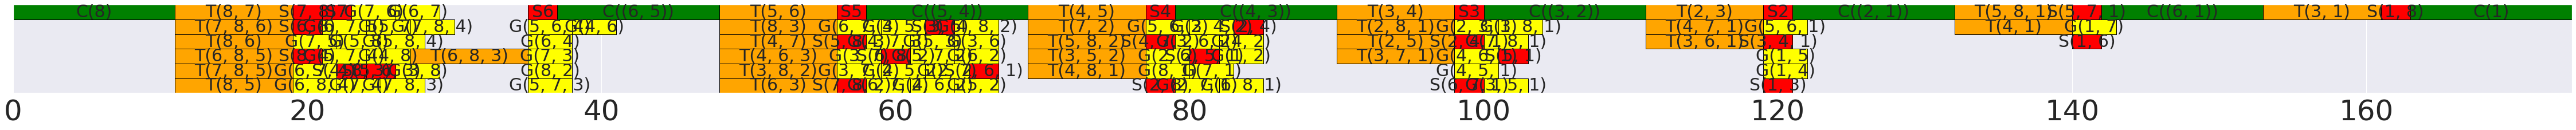

In [10]:
env.visualize_schedule()

In [7]:
import random
# random_times = []
random_times_dont_pass = []

for _ in range(10) : 
    env = CholeskyTaskGraph(8, 6, 1)
    print(len(env.task_data.x))
    observation = env.reset()
    done = False

    while not done:
#         policy, value = model(observation)
        # action_raw = random.randint(0, len(env.ready_tasks))
        action_raw = random.randint(0, len(env.ready_tasks)-1)
        if action_raw == len(env.ready_tasks):
            print("pass")
            action = -1
        else:
            action = env.ready_tasks[action_raw]
        observation, reward, done, info = env.step(action)
#     print(reward)
    print(env.time)
    random_times_dont_pass.append(env.time)
print(sum(random_times_dont_pass)/10)
print(np.std(random_times_dont_pass))

121
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
176.0
121
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
173.0
121
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
175.0
121
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
171.0
121
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
176.0
121
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
what
177.0
121
what
what
what
w

/home/nathan/anaconda3/envs/GRAN/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/nathan/anaconda3/envs/GRAN/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
/home/nathan/anaconda3/envs/GRAN/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/nathan/anaconda3/envs/GRAN/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be

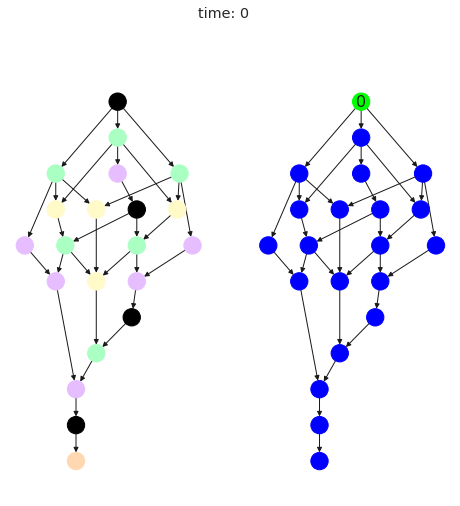

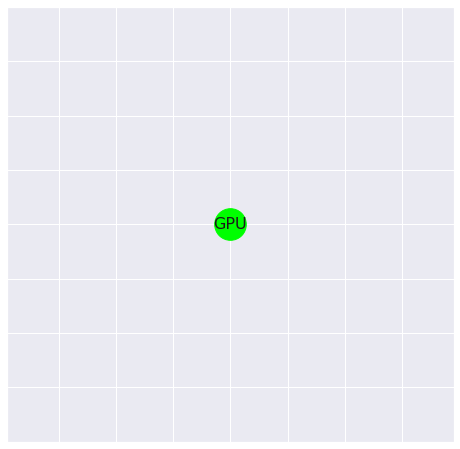

In [15]:
env.visualize_schedule()

In [3]:
# ns = list(range(1, 15))
# ps = list(range(1, 10))
temp = 1
ns = [1, 2, 4, 6, 8, 10, 15, 20, 25]
ps = [2, 3, 4, 5, 6, 8, 10]
rewards = np.zeros((len(ns), len(ps)))
times = np.zeros((len(ns), len(ps)))
critical_path = np.zeros((len(ns), len(ps)))
total_work_normalized = np.zeros((len(ns), len(ps)))
temps_computation = np.zeros((len(ns), len(ps)))

for i, n in enumerate(ns):
    for j, p in enumerate(ps):
        env = CholeskyTaskGraph(n, p, 1)
        print(env.is_homogene)
        print(len(env.task_data.x))
        observation = env.reset()
        done = False
        start_time = time.time()
        while not done:
            policy, value = model(observation)
    #         new_policy = policy ** temp / ((policy ** temp).sum())
    #         action_raw = torch.multinomial(new_policy, 1).detach().cpu().numpy()[0]
            action_raw = policy.argmax().detach().cpu().numpy()
            ready_nodes = observation['ready'].squeeze(1).to(torch.bool)
            # action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0][0]
            action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0]
            observation, reward, done, info = env.step(action)
        print(reward)
        print(env.time)
        rewards[i, j] = reward
        times[i, j] = env.time
        critical_path[i, j] = env.critic_path_duration
        total_work_normalized[i, j] = env.total_work_normalized
        temps_computation[i, j] = time.time() - start_time
        print(env.critic_path_duration)

True
2
-0.0
11.0
11
True
2
-0.0
11.0
11
True
2
-0.0
11.0
11
True
2
-0.0
11.0
11
True
2
-0.0
11.0
11
True
2
-0.0
11.0
11
True
2
-0.0
11.0
11
True
5
-0.0
32.0
32
True
5
-0.0
32.0
32
True
5
-0.0
32.0
32
True
5
-0.0
32.0
32
True
5
-0.0
32.0
32
True
5
-0.0
32.0
32
True
5
-0.0
32.0
32
True
21


/home/nathan/PycharmProjects/HPC/model.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(probs)


-0.0
74.0
74
True
21
-0.0
74.0
74
True
21
-0.0
74.0
74
True
21
-0.0
74.0
74
True
21
-0.0
74.0
74
True
21
-0.0
74.0
74
True
21
-0.0
74.0
74
True
57
-0.16666666666666666
161.0
116
True
57
-0.034482758620689655
120.0
116
True
57
-0.02586206896551724
119.0
116
True
57
-0.02586206896551724
119.0
116
True
57
-0.02586206896551724
119.0
116
True
57
-0.02586206896551724
119.0
116
True
57
-0.017241379310344827
118.0
116
True
121
-0.08955223880597014
292.0
158
True
121
-0.1473880597014926
205.0
158
True
121
-0.06329113924050633
168.0
158
True
121
-0.06329113924050633
168.0
158
True
121
-0.06329113924050633
168.0
158
True
121
-0.056962025316455694
167.0
158
True
121
-0.0379746835443038
164.0
158
True
221
-0.043478260869565216
480.0
200
True
221
-0.08913043478260863
334.0
200
True
221
-0.15217391304347827
265.0
200
True
221
-0.12
224.0
200
True
221
-0.115
223.0
200
True
221
-0.12
224.0
200
True
221
-0.085
217.0
200
True
681
-0.01937984496124031
1315.0
305
True
681
-0.03837209302325582
893.0
305
Tru

In [22]:
# Compare with ASAP:

times_asap = np.zeros((len(ns), len(ps)))
nb_nodes = np.zeros((len(ns), len(ps)))
for i, n in enumerate(ns):
    for j, p in enumerate(ps):
        env = CholeskyTaskGraph(n, p, 1)
        print(len(env.task_data.x))
        observation = env.reset()
        done = False

        while not done:
            ready_nodes = observation['ready'].squeeze(1).to(torch.bool)
            # policy, value = model(observation)
            policy = observation["graph"].x[ready_nodes][:, -1]
            # action_raw = torch.multinomial(policy, 1).detach().cpu().numpy()
            action_raw = policy.argmax().detach().cpu().numpy()
            # action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0][0]
            action = observation['node_num'][ready_nodes][action_raw].detach().numpy()[0]
            observation, reward, done, info = env.step(action)
        times_asap[i, j] = env.time
        nb_nodes[i, j] = len(env.task_data.x)
        print(reward)
        print(env.time)

2
-0.0
11.0
2
-0.0
11.0
2
-0.0
11.0
2
-0.0
11.0
2
-0.0
11.0
2
-0.0
11.0
2
-0.0
11.0
5
-0.0
32.0
5
-0.0
32.0
5
-0.0
32.0
5
-0.0
32.0
5
-0.0
32.0
5
-0.0
32.0
5
-0.0
32.0
21
-0.0
74.0
21
-0.0
74.0
21
-0.0
74.0
21
-0.0
74.0
21
-0.0
74.0
21
-0.0
74.0
21
-0.0
74.0
57
-0.11594202898550725
154.0
57
-0.0
116.0
57
-0.0
116.0
57
-0.0
116.0
57
-0.0
116.0
57
-0.0
116.0
57
-0.0
116.0
121
-0.05223880597014925
282.0
121
-0.10820895522388066
198.0
121
-0.012658227848101266
160.0
121
-0.0
158.0
121
-0.0
158.0
121
-0.0
158.0
121
-0.0
158.0
221
-0.02608695652173913
472.0
221
-0.06630434782608689
327.0
221
-0.11304347826086956
256.0
221
-0.065
213.0
221
-0.0
200.0
221
-0.0
200.0
221
-0.0
200.0
681
-0.009302325581395349
1302.0
681
-0.023255813953488372
880.0
681
-0.03565891472868217
668.0
681
-0.05426356589147287
544.0
681
-0.07441860465116279
462.0
681
-0.11937984496124031
361.0
681
-0.0
305.0
1541
-0.004332129963898917
2782.0
1541
-0.011010830324909706
1867.0
1541
-0.01660649819494585
1408.0
1541
-0.02527

In [25]:
times_asap

array([[  11.,   11.,   11.,   11.,   11.,   11.,   11.],
       [  32.,   32.,   32.,   32.,   32.,   32.,   32.],
       [  74.,   74.,   74.,   74.,   74.,   74.,   74.],
       [ 154.,  116.,  116.,  116.,  116.,  116.,  116.],
       [ 282.,  198.,  160.,  158.,  158.,  158.,  158.],
       [ 472.,  327.,  256.,  213.,  200.,  200.,  200.],
       [1302.,  880.,  668.,  544.,  462.,  361.,  305.],
       [2782., 1867., 1408., 1136.,  954.,  729.,  597.],
       [5100., 3412., 2567., 2063., 1727., 1309., 1060.]])

In [5]:
times

array([[  11.,   11.,   11.,   11.,   11.,   11.,   11.],
       [  32.,   32.,   32.,   32.,   32.,   32.,   32.],
       [  74.,   74.,   74.,   74.,   74.,   74.,   74.],
       [ 161.,  120.,  119.,  119.,  119.,  119.,  118.],
       [ 292.,  205.,  168.,  168.,  168.,  167.,  164.],
       [ 480.,  334.,  265.,  224.,  223.,  224.,  217.],
       [1315.,  893.,  709.,  614.,  506.,  407.,  365.],
       [2802., 1900., 1437., 1209., 1042.,  808.,  664.],
       [5124., 3453., 2590., 2112., 1790., 1382., 1130.]])

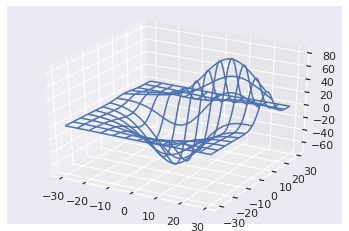

In [8]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

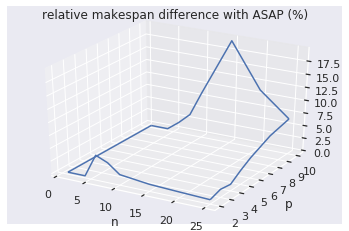

In [40]:
ns_plot = np.repeat(np.array(ns)[:, np.newaxis], len(ps), axis=1)
ps_plot = np.repeat(np.array(ps)[np.newaxis, :], len(ns), axis=0)
# print(ps_plot)
# print(ns_plot)

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
ax.plot_wireframe(ns_plot, ps_plot, (times - times_asap)/times_asap * 100, rstride=10, cstride=10)
# ax.plot_wireframe(ns_plot, ps_plot, times_asap, rstride=10, cstride=10)
plt.xlabel('n')
plt.ylabel('p')
plt.title('relative makespan difference with ASAP (%)')
plt.savefig('/home/nathan/Documents/p_n_makespan_n8_p4.pdf')
plt.show()


In [20]:

print(times)

[[  11.   11.   11.   11.   11.   11.   11.]
 [  32.   32.   32.   32.   32.   32.   32.]
 [  74.   74.   74.   74.   74.   74.   74.]
 [ 161.  120.  119.  119.  119.  119.  118.]
 [ 292.  205.  168.  168.  168.  167.  164.]
 [ 480.  334.  265.  224.  223.  224.  217.]
 [1315.  893.  709.  614.  506.  407.  365.]
 [2802. 1900. 1437. 1209. 1042.  808.  664.]
 [5124. 3453. 2590. 2112. 1790. 1382. 1130.]]


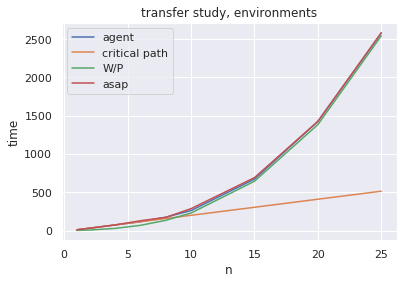

In [10]:
plt.title('transfer study, environments')
plt.plot(ns, times, label='agent')
plt.plot(ns, critical_path, label='critical path')
plt.plot(ns, total_work_normalized, label='W/P')
plt.plot(ns, times_asap, label="asap")
plt.xlabel('n')
plt.ylabel('time')
plt.legend()
plt.savefig('/home/nathan/Documents/transfer_env_15_vs_ASAP.pdf')

In [10]:
ns

[1, 2, 4, 6, 8, 10, 15, 20, 25]

In [11]:
np.array(times)/np.array(times_asap)

array([1.        , 1.        , 1.        , 1.02586207, 1.05      ,
       1.03515625, 1.06137725, 1.02059659, 1.00895988])

In [ ]:
plt.title('transfer study, environments')
plt.plot(ns, np.array(times)/np.array(times_asap))
# plt.plot(ns, times_asap, label="asap")
plt.xlabel('n')
plt.ylabel('time ratio agent/asap')
# plt.legend()
plt.savefig('/home/nathan/Documents/transfer_env_15_vs_ASAP2.pdf')

In [ ]:
# plt.title('mean computation time per action')
plt.plot(nb_nodes, np.array(temps_computationw0)/np.array(nb_nodes), label='w=0')
plt.plot(nb_nodes, np.array(temps_computationw1)/np.array(nb_nodes), label='w=1')
plt.plot(nb_nodes, np.array(temps_computationw2)/np.array(nb_nodes), label='w=2')
plt.plot(nb_nodes, np.array(temps_computationw3)/np.array(nb_nodes), label='w=3')
plt.plot(nb_nodes, np.array(temps_computationw4)/np.array(nb_nodes), label='w=4')
plt.xlabel('|V|')
plt.ylabel('time (s)')
plt.legend()
plt.savefig('/home/nathan/Documents/time_for_windows.pdf')

In [ ]:
plt.title('time cost')
plt.plot(nb_nodes, temps_computationw0, label='agent computation cost')
plt.xlabel('number of nodes')
plt.ylabel('time (s)')
plt.legend()
plt.savefig('/home/nathan/Documents/transfer_env_8_time_cost.pdf')

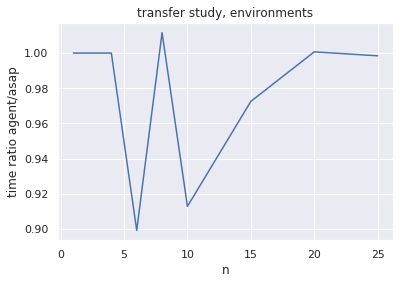

In [11]:
plt.title('time cost')
plt.plot(ns, temps_computation, label='agent computation cost')
plt.xlabel('n')
plt.ylabel('time (s)')
plt.legend()
plt.savefig('/home/nathan/Documents/transfer_env_8_time_cost_n.pdf')

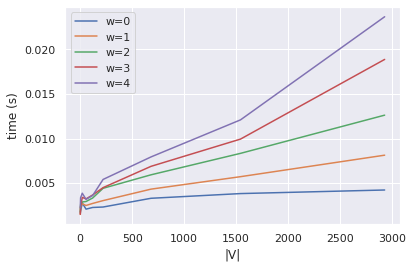

In [27]:
# plt.title('mean computation time per action')
plt.plot(nb_nodes, np.array(temps_computationw0)/np.array(nb_nodes), label='w=0')
plt.plot(nb_nodes, np.array(temps_computationw1)/np.array(nb_nodes), label='w=1')
plt.plot(nb_nodes, np.array(temps_computationw2)/np.array(nb_nodes), label='w=2')
plt.plot(nb_nodes, np.array(temps_computationw3)/np.array(nb_nodes), label='w=3')
plt.plot(nb_nodes, np.array(temps_computationw4)/np.array(nb_nodes), label='w=4')
plt.xlabel('|V|')
plt.ylabel('time (s)')
plt.legend()
plt.savefig('/home/nathan/Documents/time_for_windows.pdf')

ValueError: x and y must have same first dimension, but have shapes (1,) and (9,)

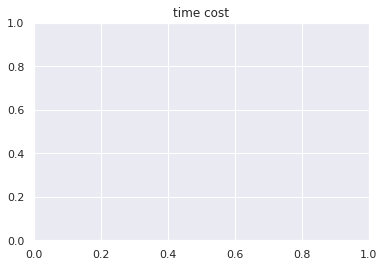

In [10]:
plt.title('time cost')
plt.plot(nb_nodes, temps_computationw0, label='agent computation cost')
plt.xlabel('number of nodes')
plt.ylabel('time (s)')
plt.legend()
plt.savefig('/home/nathan/Documents/transfer_env_8_time_cost.pdf')

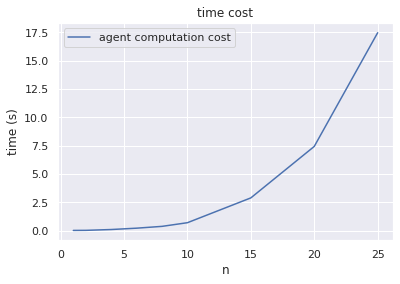

In [9]:
plt.title('time cost')
plt.plot(ns, temps_computation, label='agent computation cost')
plt.xlabel('n')
plt.ylabel('time (s)')
plt.legend()
plt.savefig('/home/nathan/Documents/transfer_env_8_time_cost_n.pdf')

In [ ]:
# ns = list(range(1, 15))
# ps = list(range(1, 10))
temp = 40
n_sample = 20
rewards = []
times_40 = []
critical_path = []
total_work_normalized = []

for i in range(n_sample): 
    env = CholeskyTaskGraph(8, 4, 1)
    print(len(env.task_data.x))
    observation = env.reset()
    done = False

    while not done:
        policy, value = model(observation)
        new_policy = policy ** temp / ((policy ** temp).sum())
        action_raw = torch.multinomial(F.relu(new_policy), 1).detach().cpu().numpy()[0]
#         action_raw = policy.argmax().detach().cpu().numpy()
        ready_nodes = observation['ready'].squeeze(1).to(torch.bool)
        # action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0][0]
        action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0]
        observation, reward, done, info = env.step(action)
    print(reward)
    print(env.time)
    rewards.append(reward)
    times_40.append(env.time)
    critical_path.append(env.critic_path_duration)
    total_work_normalized.append(env.total_work_normalized)

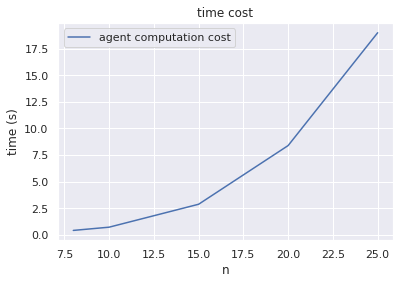

In [9]:
# ns = list(range(1, 15))
# ps = list(range(1, 10))
temp = 40
n_sample = 20
rewards = []
times_40 = []
critical_path = []
total_work_normalized = []

for i in range(n_sample): 
    env = CholeskyTaskGraph(8, 4, 1)
    print(len(env.task_data.x))
    observation = env.reset()
    done = False

    while not done:
        policy, value = model(observation)
        new_policy = policy ** temp / ((policy ** temp).sum())
        action_raw = torch.multinomial(F.relu(new_policy), 1).detach().cpu().numpy()[0]
#         action_raw = policy.argmax().detach().cpu().numpy()
        ready_nodes = observation['ready'].squeeze(1).to(torch.bool)
        # action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0][0]
        action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0]
        observation, reward, done, info = env.step(action)
    print(reward)
    print(env.time)
    rewards.append(reward)
    times_40.append(env.time)
    critical_path.append(env.critic_path_duration)
    total_work_normalized.append(env.total_work_normalized)

In [3]:
# ns = list(range(1, 15))
# ps = list(range(1, 10))
temp = 40
n_sample = 20
rewards = []
times_40 = []
critical_path = []
total_work_normalized = []

for i in range(n_sample): 
    env = CholeskyTaskGraph(8, 4, 1)
    print(len(env.task_data.x))
    observation = env.reset()
    done = False

    while not done:
        policy, value = model(observation)
        new_policy = policy ** temp / ((policy ** temp).sum())
        action_raw = torch.multinomial(F.relu(new_policy), 1).detach().cpu().numpy()[0]
#         action_raw = policy.argmax().detach().cpu().numpy()
        ready_nodes = observation['ready'].squeeze(1).to(torch.bool)
        # action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0][0]
        action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0]
        observation, reward, done, info = env.step(action)
    print(reward)
    print(env.time)
    rewards.append(reward)
    times_40.append(env.time)
    critical_path.append(env.critic_path_duration)
    total_work_normalized.append(env.total_work_normalized)

NameError: name 'CholeskyTaskGraph' is not defined

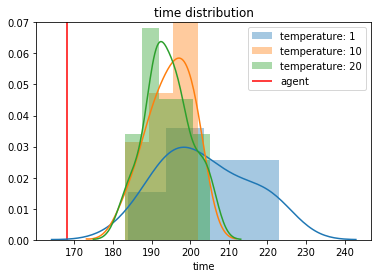

In [75]:
plt.title('time distribution')
sns.distplot(times_1, label='temperature: 1')
sns.distplot(times_10, label='temperature: 10')
sns.distplot(times_20, label='temperature: 20')
plt.vlines(168, 0, 0.07, label='agent', colors='r')
plt.ylim(0, 0.07)
plt.xlabel('time')
plt.legend()
plt.savefig('/home/nathan/Documents/time_distrib_agent_168.pdf')

In [4]:
dont_pass = []

for p in ps: 
    env = CholeskyTaskGraph(8, p, 1)
    print(len(env.task_data.x))
    observation = env.reset()
    done = False
    
    while not done:
        action = env.ready_tasks[0]
        observation, reward, done, info = env.step(action)
    dont_pass.append(env.time)

121
121
121
121
121
121
121
121
121


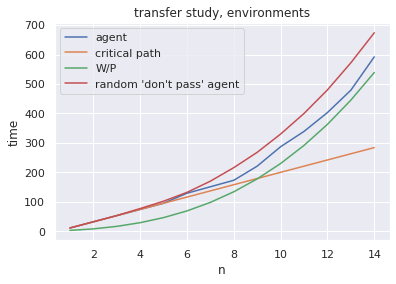

In [57]:
plt.title('transfer study, environments')
plt.plot(ns, times, label='agent')
plt.plot(ns, critical_path, label='critical path')
plt.plot(ns, total_work_normalized, label='W/P')
plt.plot(ns, dont_pass, label="random 'don't pass' agent")
plt.xlabel('n')
plt.ylabel('time')
plt.legend()
plt.savefig('/home/nathan/Documents/transfer_env_8_w_1.pdf')

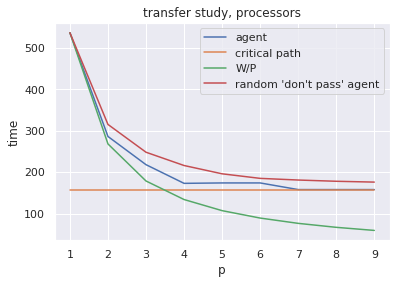

In [7]:
plt.title('transfer study, processors')
plt.plot(ps, times, label='agent')
plt.plot(ps, critical_path, label='critical path')
plt.plot(ps, total_work_normalized, label='W/P')
plt.plot(ps, dont_pass, label="random 'don't pass' agent")
plt.xlabel('p')
plt.ylabel('time')
plt.legend()
plt.savefig('/home/nathan/Documents/transfer_p_8_w_2.pdf')

In [30]:
import random
# random_times = []
random_times_dont_pass = []

for _ in range(50) : 
    env = CholeskyTaskGraph(8, 4, 1)
    print(len(env.task_data.x))
    observation = env.reset()
    done = False

    while not done:
        policy, value = model(observation)
        # action_raw = random.randint(0, len(env.ready_tasks))
        action_raw = random.randint(0, len(env.ready_tasks)-1)
        if action_raw == len(env.ready_tasks):
            action = -1
        else:
            action = env.ready_tasks[action_raw]
        observation, reward, done, info = env.step(action)
    print(reward)
    print(env.time)
    random_times_dont_pass.append(env.time)

121
-0.34810126582278483
213.0
121
-0.17721518987341772
186.0
121
-0.27848101265822783
202.0
121
-0.31645569620253167
208.0
121
-0.26582278481012656
200.0
121
-0.31645569620253167
208.0
121
-0.22784810126582278
194.0
121
-0.25316455696202533
198.0
121
-0.26582278481012656
200.0
121
-0.2721518987341772
201.0
121
-0.21518987341772153
192.0
121
-0.14556962025316456
181.0
121
-0.17088607594936708
185.0
121
-0.25949367088607594
199.0
121
-0.189873417721519
188.0
121
-0.310126582278481
207.0
121
-0.20253164556962025
190.0
121
-0.22784810126582278
194.0
121
-0.15822784810126583
183.0
121
-0.25949367088607594
199.0
121
-0.22784810126582278
194.0
121
-0.2088607594936709
191.0
121
-0.189873417721519
188.0
121
-0.25316455696202533
198.0
121
-0.25949367088607594
199.0
121
-0.2721518987341772
201.0
121
-0.18354430379746836
187.0
121
-0.22784810126582278
194.0
121
-0.24050632911392406
196.0
121
-0.23417721518987342
195.0
121
-0.22784810126582278
194.0
121
-0.23417721518987342
195.0
121
-0.2594936708

/home/nathan/PycharmProjects/HPC/model.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(probs)


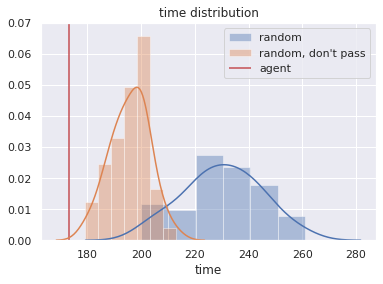

In [56]:
plt.title('time distribution')
sns.distplot(random_times, label='random')
sns.distplot(random_times_dont_pass, label="random, don't pass")
plt.vlines(times[7], 0, 0.07, label='agent', colors='r')
plt.ylim(0, 0.07)
plt.xlabel('time')
plt.legend()
plt.savefig('/home/nathan/Documents/time_distrib_8_4_1.pdf')

In [33]:
# ASAP in my case

env = CholeskyTaskGraph(8, 4, 1)
print(len(env.task_data.x))
observation = env.reset()
done = False

while not done:
    ready_nodes = observation['ready'].squeeze(1).to(torch.bool)
    # policy, value = model(observation)
    policy = observation["graph"].x[ready_nodes][:, -1]
    # action_raw = torch.multinomial(policy, 1).detach().cpu().numpy()
    action_raw = policy.argmax().detach().cpu().numpy()
    # action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0][0]
    action = observation['node_num'][ready_nodes][action_raw].detach().numpy()[0]
    observation, reward, done, info = env.step(action)
print(reward)
print(env.time)


121
-0.012658227848101266
160.0


In [15]:
def start_time(time, makespan):
    return makespan - time
    
def get_data(env):
    P = env.p
    Processed = env.processed
    processed = {}
    for k, v in Processed.items():
        processed[k] = [int(v[0]), int(env.time - v[1])] 
    Processed = processed
    
    #makespan should be dicrete and durations should be discretized
    makespan = Processed[(0,1,0,0)][1]
    current_times = [[makespan]*P]
    data = np.ones((P, makespan)) * (-1)
    data = data.astype(int)
    compl_data = [[] for _ in range(P)]
    #data = [[]*P]
    for x, sched in Processed.items():
        tasktype = x[0]
        pr = sched[0]
        s_time = start_time(sched[1], makespan)
        e_time = s_time + Task(x).durations[env.cluster.node_types[pr]] 
        data[pr, s_time:e_time] = tasktype
        #print('process', pr)
        if tasktype == 0:
            compl_data[pr].insert(0, (x[1]))
        elif tasktype == 1:
            compl_data[pr].insert(0, (x[1], x[2]))
        elif tasktype == 2:
            compl_data[pr].insert(0, (x[1], x[2]))
        else:
            compl_data[pr].insert(0, (x[1], x[2], x[3]))
        #print('here', len(compl_data[0]), len(compl_data[1]), len(compl_data[2]), len(compl_data[3]))

    return data, compl_data

def visualize_schedule(env, figsize = (80,30), fig_file = None, flip = True):
    data, compl_data = get_data(env)
    if flip:
        data = data[-1::-1, :]
        compl_data = compl_data[-1::-1]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_aspect(1)

    def avg(a, b):
        return (a + b) / 2.0

    for y, row in enumerate(data):
        #for x, col in enumerate(row):
        x = 0
        i = 0
        indices_in_row = compl_data[y]
        while x < len(row): 
            col = row[x]
            if col != -1:
                shift = Task([col]).durations[env.cluster.node_types[y]]
                indices = indices_in_row[i]
            else: 
                x = x + 1
                continue
            x1 = [x, x+shift]
            y1 = np.array([y, y])
            y2 = y1+1
            if col == 0:
                plt.fill_between(x1, y1, y2 = y2, facecolor= 'green', edgecolor = 'Black')
                plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), 'C({})'.format(indices), 
                                            horizontalalignment = 'center',
                                            verticalalignment = 'center', fontsize=30)

            if col == 1:
                plt.fill_between(x1, y1, y2=y2, facecolor='red', edgecolor = 'Black')
                plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), "S{}".format(indices), 
                                            horizontalalignment='center',
                                            verticalalignment='center', fontsize=30)
            if col == 2:
                plt.fill_between(x1, y1, y2=y2, facecolor='orange', edgecolor = 'Black')
                plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), "T{}".format(indices), 
                                            horizontalalignment='center',
                                            verticalalignment='center', fontsize=30)
            if col == 3:
                plt.fill_between(x1, y1, y2=y2, facecolor='yellow', edgecolor = 'Black')
                plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), "G{}".format(indices), 
                                            horizontalalignment='center',
                                            verticalalignment='center', fontsize=30)
            x = x + shift
            i = i + 1

    plt.ylim(P, 0)
    plt.xlim(-1e-3, data.shape[1] + 1e-3)
    plt.xticks(fontsize=50)
    if fig_file != None:
        plt.savefig(fig_file)
    return

In [18]:
visualize_schedule(env.processed, figsize=(200, 100),fig_file = '/home/nathan/PycharmProjects/HPC/img/sched_train_n=4_test_n=8.pdf')

AttributeError: 'dict' object has no attribute 'p'

In [14]:
env.processed

{(0, 1, 0, 0): [0, 0],
 (2, 1, 8, 0): [0, 1.0],
 (2, 1, 7, 0): [1, 1.0],
 (2, 1, 6, 0): [2, 1.0],
 (2, 1, 5, 0): [3, 1.0],
 (1, 7, 1, 0): [0, 4.0],
 (1, 8, 1, 0): [1, 4.0],
 (3, 7, 8, 1): [0, 7.0],
 (2, 1, 4, 0): [1, 7.0],
 (1, 5, 1, 0): [2, 9.0],
 (1, 6, 1, 0): [3, 9.0],
 (1, 4, 1, 0): [1, 10.0],
 (3, 4, 5, 1): [2, 11.0],
 (3, 5, 6, 1): [3, 11.0],
 (3, 4, 6, 1): [0, 13.0],
 (3, 6, 7, 1): [1, 13.0],
 (3, 5, 7, 1): [2, 14.0],
 (3, 4, 7, 1): [3, 14.0],
 (3, 6, 8, 1): [2, 17.0],
 (3, 5, 8, 1): [3, 17.0],
 (3, 4, 8, 1): [0, 19.0],
 (2, 1, 3, 0): [1, 19.0],
 (2, 1, 2, 0): [2, 20.0],
 (1, 3, 1, 0): [1, 22.0],
 (3, 3, 4, 1): [3, 22.0],
 (3, 3, 5, 1): [0, 25.0],
 (3, 3, 6, 1): [1, 25.0],
 (3, 3, 7, 1): [3, 25.0],
 (1, 2, 1, 0): [2, 28.0],
 (3, 2, 3, 1): [3, 28.0],
 (0, 2, 0, 0): [2, 30.0],
 (3, 2, 4, 1): [0, 31.0],
 (3, 2, 5, 1): [1, 31.0],
 (3, 2, 6, 1): [3, 31.0],
 (3, 2, 7, 1): [3, 34.0],
 (3, 3, 8, 1): [0, 37.0],
 (3, 2, 8, 1): [1, 37.0],
 (2, 2, 3, 0): [2, 41.0],
 (2, 2, 4, 0): [3, 41.0],

In [6]:
env = CholeskyTaskGraph(8, np.array([0, 0, 1, 1]), 1)
print(len(env.task_data.x))
observation = env.reset()
done = False

while not done:
    policy, value = model(observation)
#     new_policy = policy ** temp / ((policy ** temp).sum())
#     action_raw = torch.multinomial(F.relu(new_policy), 1).detach().cpu().numpy()[0]
    action_raw = policy.argmax().detach().cpu().numpy()
    ready_nodes = observation['ready'].squeeze(1).to(torch.bool)
#     action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0][0]
    action = -1 if action_raw == policy.shape[-1] - 1 else observation['node_num'][ready_nodes][action_raw].detach().numpy()[0]
    observation, reward, done, info = env.step(action)

121


/home/nathan/PycharmProjects/HPC/model.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(probs)


In [11]:
env.processed

{(0, 1, 0, 0): [0, 0],
 (2, 1, 8, 0): [0, 1.0],
 (2, 1, 7, 0): [1, 1.0],
 (2, 1, 6, 0): [2, 1.0],
 (2, 1, 5, 0): [3, 1.0],
 (1, 7, 1, 0): [0, 4.0],
 (1, 8, 1, 0): [1, 4.0],
 (3, 7, 8, 1): [0, 7.0],
 (2, 1, 4, 0): [1, 7.0],
 (1, 5, 1, 0): [2, 9.0],
 (1, 6, 1, 0): [3, 9.0],
 (1, 4, 1, 0): [1, 10.0],
 (3, 4, 5, 1): [2, 11.0],
 (3, 5, 6, 1): [3, 11.0],
 (3, 4, 6, 1): [0, 13.0],
 (3, 6, 7, 1): [1, 13.0],
 (3, 5, 7, 1): [2, 14.0],
 (3, 4, 7, 1): [3, 14.0],
 (3, 6, 8, 1): [2, 17.0],
 (3, 5, 8, 1): [3, 17.0],
 (3, 4, 8, 1): [0, 19.0],
 (2, 1, 3, 0): [1, 19.0],
 (2, 1, 2, 0): [2, 20.0],
 (1, 3, 1, 0): [1, 22.0],
 (3, 3, 4, 1): [3, 22.0],
 (3, 3, 5, 1): [0, 25.0],
 (3, 3, 6, 1): [1, 25.0],
 (3, 3, 7, 1): [3, 25.0],
 (1, 2, 1, 0): [2, 28.0],
 (3, 2, 3, 1): [3, 28.0],
 (0, 2, 0, 0): [2, 30.0],
 (3, 2, 4, 1): [0, 31.0],
 (3, 2, 5, 1): [1, 31.0],
 (3, 2, 6, 1): [3, 31.0],
 (3, 2, 7, 1): [3, 34.0],
 (3, 3, 8, 1): [0, 37.0],
 (3, 2, 8, 1): [1, 37.0],
 (2, 2, 3, 0): [2, 41.0],
 (2, 2, 4, 0): [3, 41.0],

IndexError: list index out of range

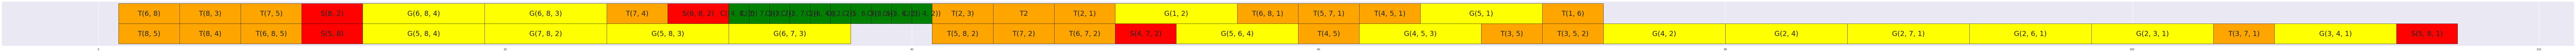

In [16]:
visualize_schedule(env, figsize=(200, 100),fig_file = '/home/nathan/PycharmProjects/HPC/img/test.pdf')

In [16]:
env

In [ ]:
env.prov

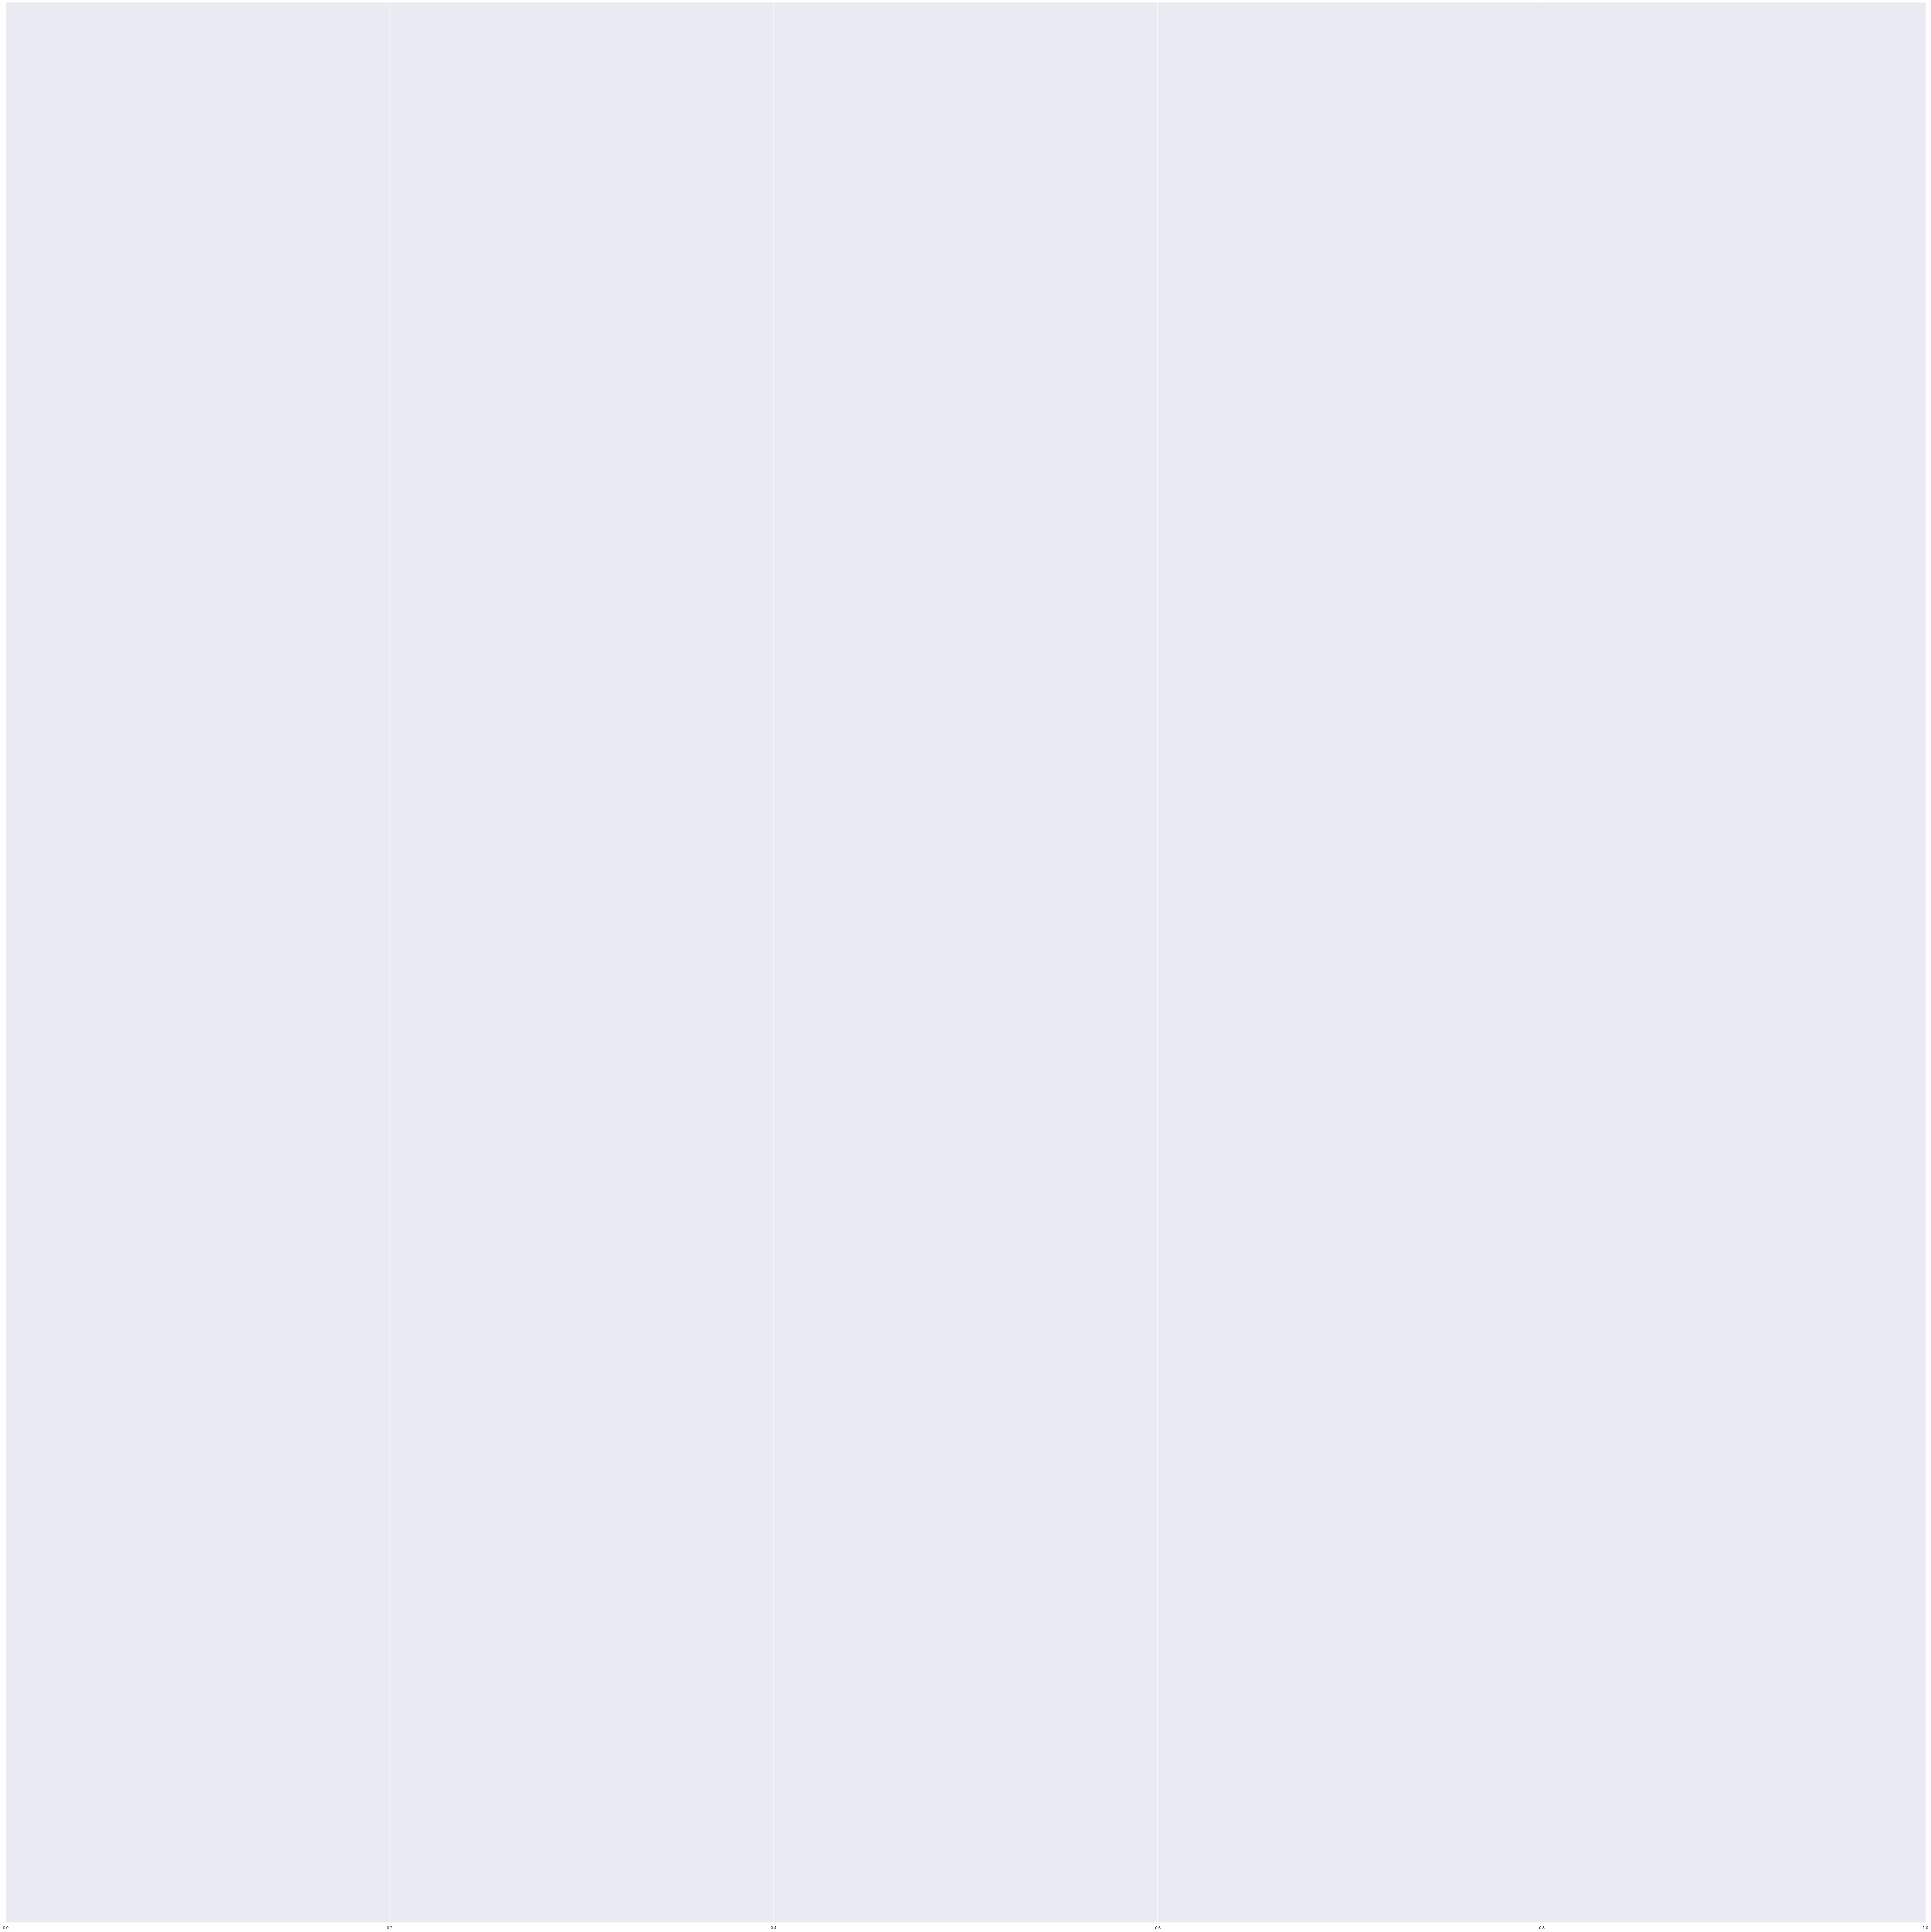

In [19]:
data, compl_data = get_data(env)
if True:
    data = data[-1::-1, :]
    compl_data = compl_data[-1::-1]

fig = plt.figure(figsize=(200, 100))
ax = fig.add_subplot(111)
ax.axes.get_yaxis().set_visible(False)
ax.set_aspect(1)

def avg(a, b):
    return (a + b) / 2.0

In [24]:
print(data.shape)
print(len(compl_data))

(4, 133)
4


In [31]:
print(len(compl_data[0]))


29


In [ ]:
for y, row in enumerate(data):
    #for x, col in enumerate(row):
    x = 0
    i = 0
    indices_in_row = compl_data[y]
    while x < len(row): 
        col = row[x]
        if col != -1:
            shift = Task([col]).durations[env.cluster.node_types[y]]
            indices = indices_in_row[i]
        else: 
            x = x + 1
            continue
        x1 = [x, x+shift]
        y1 = np.array([y, y])
        y2 = y1+1
        if col == 0:
            plt.fill_between(x1, y1, y2 = y2, facecolor= 'green', edgecolor = 'Black')
            plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), 'C({})'.format(indices), 
                                        horizontalalignment = 'center',
                                        verticalalignment = 'center', fontsize=30)

        if col == 1:
            plt.fill_between(x1, y1, y2=y2, facecolor='red', edgecolor = 'Black')
            plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), "S{}".format(indices), 
                                        horizontalalignment='center',
                                        verticalalignment='center', fontsize=30)
        if col == 2:
            plt.fill_between(x1, y1, y2=y2, facecolor='orange', edgecolor = 'Black')
            plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), "T{}".format(indices), 
                                        horizontalalignment='center',
                                        verticalalignment='center', fontsize=30)
        if col == 3:
            plt.fill_between(x1, y1, y2=y2, facecolor='yellow', edgecolor = 'Black')
            plt.text(avg(x1[0], x1[1]), avg(y1[0], y2[0]), "G{}".format(indices), 
                                        horizontalalignment='center',
                                        verticalalignment='center', fontsize=30)
        x = x + shift
        i = i + 1

plt.ylim(P, 0)
plt.xlim(-1e-3, data.shape[1] + 1e-3)
plt.xticks(fontsize=50)
if fig_file != None:
    plt.savefig(fig_file)
return